In [1]:
using CSV
using DataFrames
using Turing
using Logging
using StatisticalRethinking
using StatsBase
using StatsPlots

using Dagitty

default(label=false)
Logging.disable_logging(Logging.Warn);

# 5.1 Spurious association

Code 5.1

In [2]:
d = DataFrame(CSV.File("data/WaffleDivorce.csv"))
d[!,:D] = standardize(ZScoreTransform, d.Divorce)
d[!,:M] = standardize(ZScoreTransform, d.Marriage)
d[!,:A] = standardize(ZScoreTransform, d.MedianAgeMarriage);

Code 5.2

In [3]:
std(d.MedianAgeMarriage)

1.2436303013880823

Code 5.3

In [4]:
Random.seed!(100)

@model function model_m5_1(A, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    μ = @. a + bA * A
    D ~ MvNormal(μ, σ)
end

m5_1 = sample(model_m5_1(d.A, d.D), NUTS(), 1000)
m5_1_df = DataFrame(m5_1)
prior = sample(model_m5_1([0], [0]), Prior(), 1000)
prior_df = DataFrame(prior);

Code 5.4

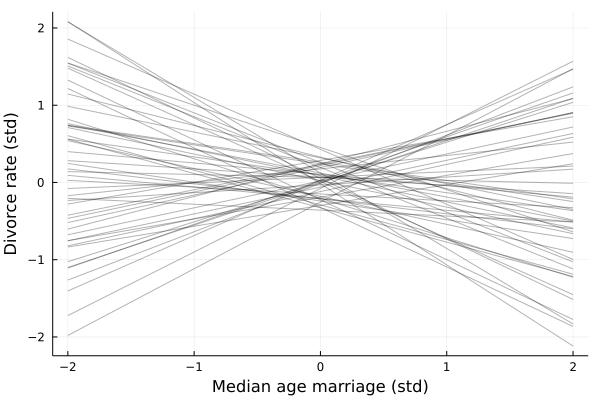

In [5]:
# calculate μ for every prior sample on age=-2 and age=2
bounds = [-2, 2]
μ = StatisticalRethinking.link(prior_df, [:a, :bA], bounds)
μ = hcat(μ...);

p = plot(xlab="Median age marriage (std)", ylab="Divorce rate (std)")
for μₚ ∈ first(eachrow(μ), 50)
    plot!(bounds, μₚ; c=:black, alpha=0.3)
end
display(p)

Code 5.5

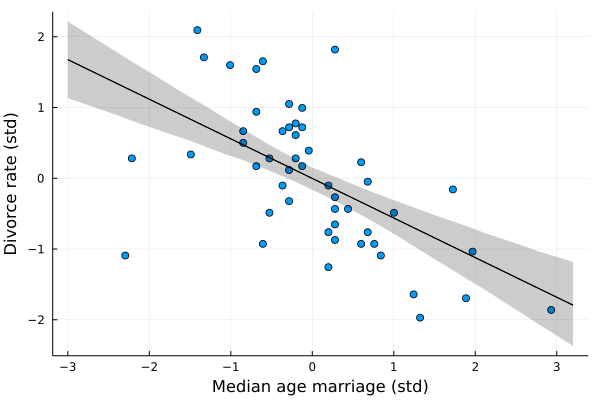

In [6]:
A_seq = range(-3, 3.2; length=30)

μ = StatisticalRethinking.link(m5_1_df, [:a, :bA], A_seq)
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df d scatter(:A, :D; xlab="Median age marriage (std)", ylab="Divorce rate (std)")
plot!(A_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.2)

Code 5.6

In [7]:
Random.seed!(100)

@model function model_m5_2(M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bM ~ Normal(0, 0.5)
    μ = @. a + bM * M
    D ~ MvNormal(μ, σ)
end

m5_2 = sample(model_m5_2(d.M, d.D), NUTS(), 1000)
m5_2_df = DataFrame(m5_2);

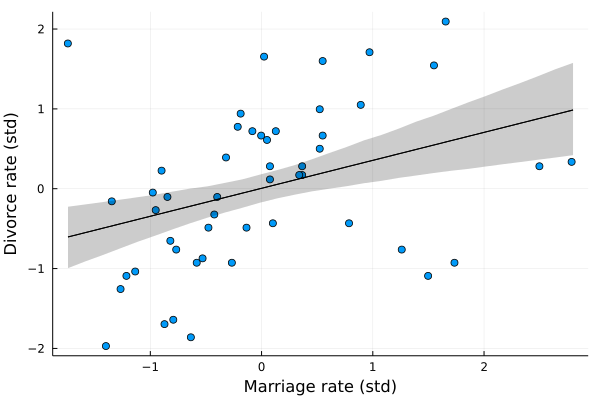

In [8]:
M_seq = range(-1.74, 2.8; length=30)

μ = StatisticalRethinking.link(m5_2_df, [:a, :bM], M_seq)
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df d scatter(:M, :D; xlab="Marriage rate (std)", ylab="Divorce rate (std)")
plot!(M_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.2)

Code 5.7

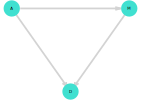

In [9]:
g = Dagitty.DAG(:A => :M, :A => :D, :M => :D)
drawdag(g, [0, 1, 2], [0, 1, 0])

Code 5.8

In [10]:
g = Dagitty.DAG(:A => :M, :A => :D)
implied_conditional_independencies(g)

1-element Vector{ConditionalIndependence}:
 ConditionalIndependence(:D, :M, [:A])

Code 5.9

In [11]:
g = Dagitty.DAG(:A => :M, :A => :D, :M => :D)
implied_conditional_independencies(g)

ConditionalIndependence[]

Code 5.10

In [12]:
@model function model_m5_3(A, M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ MvNormal(μ, σ)
end

m5_3 = sample(model_m5_3(d.A, d.M, d.D), NUTS(), 1000)
m5_3_df = DataFrame(m5_3)
precis(m5_3_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     σ │  0.8329   0.084   0.7067   0.8262   0.9761   ▁▂▅██▇▄▂▁▁▁▁ │
│     a │ -0.0045  0.0995  -0.1716    0.001   0.1461       ▁▁▄██▃▁▁ │
│    bA │  -0.609  0.1655  -0.8759  -0.6072  -0.3387   ▁▁▁▁▃▆██▅▃▁▁ │
│    bM │ -0.0665  0.1712  -0.3249  -0.0743    0.208  ▁▁▁▁▂▅██▆▄▂▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 5.11

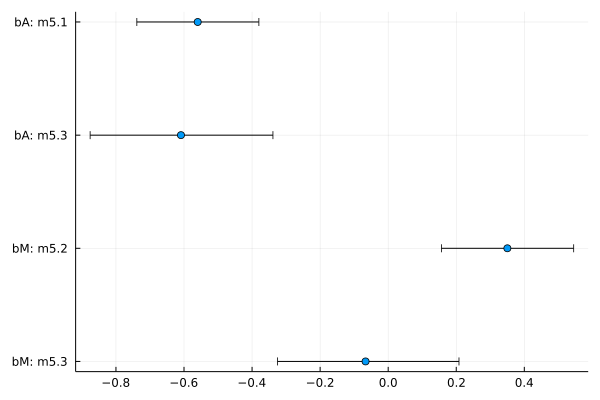

In [13]:
coeftab_plot(m5_1_df, m5_2_df, m5_3_df; pars=(:bA, :bM), names=["m5.1", "m5.2", "m5.3"])

Code 5.12

In [14]:
Random.seed!(100)
N = 50
age = rand(Normal(), N)
mar = rand.(Normal.(-age))
div = rand.(Normal.(age));

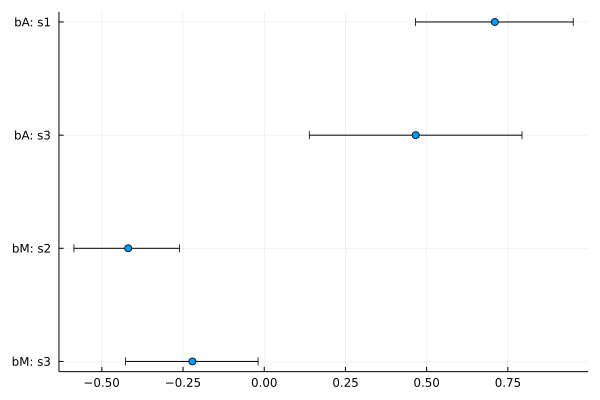

In [15]:
s1 = DataFrame(sample(model_m5_1(age, div), NUTS(), 1000))
s2 = DataFrame(sample(model_m5_2(mar, div), NUTS(), 1000))
s3 = DataFrame(sample(model_m5_3(age, mar, div), NUTS(), 1000));
coeftab_plot(s1, s2, s3; pars=(:bA, :bM), names=["s1", "s2", "s3"])

In [16]:
Random.seed!(100)
N = 50
age = rand(Normal(), N)
mar = rand.(Normal.(-age))
div = rand.(Normal.(age .+ mar));

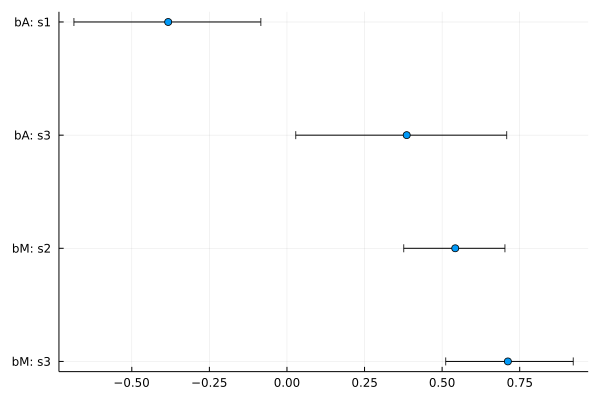

In [17]:
s1 = DataFrame(sample(model_m5_1(age, div), NUTS(), 1000))
s2 = DataFrame(sample(model_m5_2(mar, div), NUTS(), 1000))
s3 = DataFrame(sample(model_m5_3(age, mar, div), NUTS(), 1000));
coeftab_plot(s1, s2, s3; pars=(:bA, :bM), names=["s1", "s2", "s3"])

Code 5.13

In [18]:
Random.seed!(100)

@model function model_m5_4(A, M)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bAM ~ Normal(0, 0.5)
    μ = @. a + bAM * A
    M ~ MvNormal(μ, σ)
end

m5_4 = sample(model_m5_4(d.A, d.M), NUTS(), 1000)
m5_4_df = DataFrame(m5_4);

Code 5.14

In [19]:
mu = StatisticalRethinking.link(m5_4_df, [:a, :bAM], d.A);
mu = hcat(mu...)
mu_mean = mean.(eachcol(mu))
mu_resid = mu_mean .- d.M;

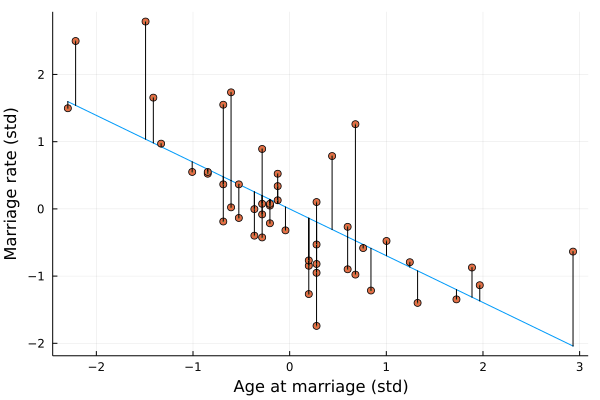

In [20]:
# Side-note: how to plot the residuals
# getting yerr - list of 2-tuples with distance to the regression line
yerr = collect(zip(-clamp.(mu_resid, -Inf, -0.0), clamp.(mu_resid, 0, Inf)));

plot(d.A, mu_mean; xlab="Age at marriage (std)", ylab="Marriage rate (std)")
scatter!(d.A, d.M)
scatter!(d.A, d.M; yerr=yerr, markersize=0)

Code 5.15

In [21]:
# explicit link form before I improved it
mu = [
    @. r.a + r.bA * d.A + r.bM * d.M
    for r ∈ eachrow(m5_3_df)
]

mu = vcat(mu'...)
mu_mean = mean.(eachcol(mu))
mu_PI = PI.(eachcol(mu))
mu_PI = vcat(mu_PI'...);

D_sim = [
    rand(MvNormal((@. r.a + r.bA * d.A + r.bM * d.M), r.σ))
    for r ∈ eachrow(m5_3_df)
]
D_sim = vcat(D_sim'...);
D_PI = PI.(eachcol(D_sim))
D_PI = vcat(D_PI'...);

Code 5.16

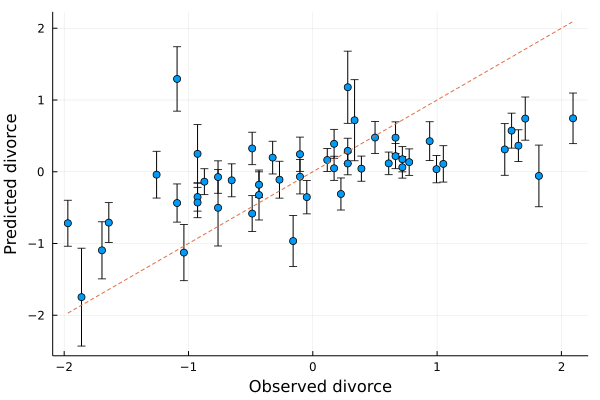

In [22]:
yerr = mu_PI[:,2] .- mu_mean
scatter(d.D, mu_mean; xlab="Observed divorce", ylab="Predicted divorce", yerr=yerr)
plot!(x->x; style=:dash)

Code 5.17

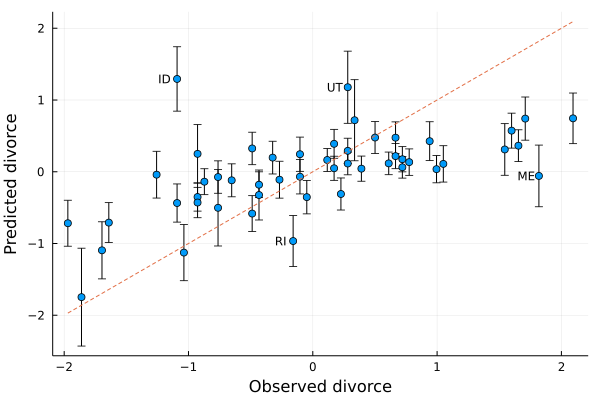

In [23]:
loc_flags = d.Loc .∈ (["ID", "UT", "RI", "ME"],);
loc_idxes = findall(loc_flags);
anns = [
    (d.D[idx] - 0.1, mu_mean[idx], (d.Loc[idx], 8))
    for idx in loc_idxes
]
annotate!(anns)

Code 5.18

In [24]:
Random.seed!(100)
N = 100
x_real = rand(Normal(), N)
x_spur = rand.(Normal.(x_real))
y = rand.(Normal.(x_real))
df = DataFrame(:y => y, :x_real => x_real, :x_spur => x_spur);

Code 5.19

In [25]:
d1 = DataFrame(CSV.File("data/WaffleDivorce.csv"))
d = DataFrame(
    :D => standardize(ZScoreTransform, d1.Divorce),
    :M => standardize(ZScoreTransform, d1.Marriage),
    :A => standardize(ZScoreTransform, d1.MedianAgeMarriage),
);

@model function model_m5_3A(A, M, D)
    # A → D ← M
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ MvNormal(μ, σ)
    # A → M
    σ_M ~ Exponential(1)
    aM ~ Normal(0, 0.2)
    bAM ~ Normal(0, 0.5)
    μ_M = @. aM + bAM * A
    M ~ MvNormal(μ_M, σ_M)
end

m5_3A = sample(model_m5_3A(d.A, d.M, d.D), NUTS(), 1000)
m5_3A_df = DataFrame(m5_3A)
precis(m5_3A_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%     histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     σ │  0.8237   0.084   0.7009   0.8169   0.9688   ▁▂▆██▆▄▂▁▁▁ │
│     a │  0.0027  0.1004  -0.1557   0.0029   0.1632  ▁▁▂▄▆██▆▄▂▁▁ │
│    bA │ -0.6083  0.1559  -0.8425  -0.6129  -0.3507   ▁▁▁▃▆█▇▅▃▁▁ │
│    bM │ -0.0675  0.1545  -0.3186  -0.0682   0.1754   ▁▁▂▄██▇▄▁▁▁ │
│   σ_M │  0.7117  0.0742   0.6038   0.7033   0.8404    ▁▂▅█▇▅▃▁▁▁ │
│    aM │  0.0021  0.0893  -0.1419   0.0048    0.139  ▁▁▂▄▆▇█▆▄▂▁▁ │
│   bAM │ -0.6906  0.1007  -0.8424  -0.6948  -0.5261      ▁▃██▃▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


Code 5.20

In [26]:
A_seq = range(-2, 2; length=30);

Code 5.21

In [27]:
s_M, s_D = [], []

for r ∈ eachrow(m5_3A_df)
    M = rand(MvNormal((@. r.aM + r.bAM * A_seq), r.σ_M))
    D = rand(MvNormal((@. r.a + r.bA * A_seq + r.bM * M), r.σ))
    push!(s_M, M)
    push!(s_D, D)
end

s_M = vcat(s_M'...)
s_D = vcat(s_D'...);

Code 5.22

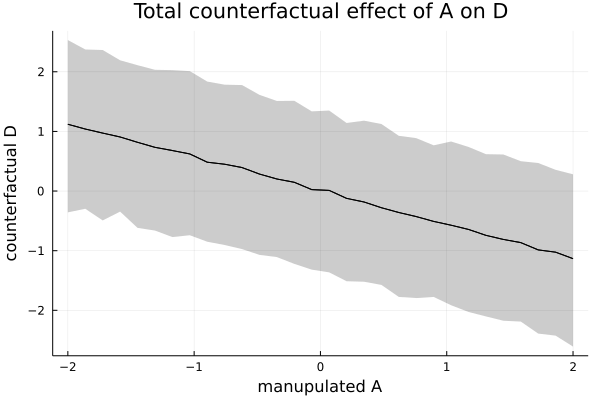

In [28]:
μ_D = mean.(eachcol(s_D))
PI_D = vcat(PI.(eachcol(s_D))'...)

plot(
    A_seq, [μ_D, μ_D]; 
    fillrange=PI_D, fillalpha=0.2, color=:black,
    xlab="manupulated A", ylab="counterfactual D",
    title="Total counterfactual effect of A on D"
)

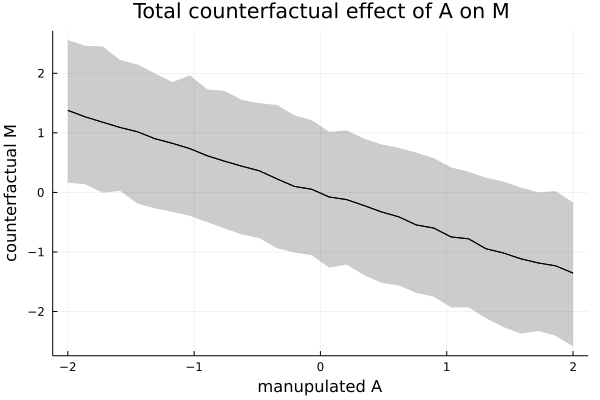

In [29]:
μ_M = mean.(eachcol(s_M))
PI_M = vcat(PI.(eachcol(s_M))'...)

plot(
    A_seq, [μ_M, μ_M]; 
    fillrange=PI_M, fillalpha=0.2, color=:black,
    xlab="manupulated A", ylab="counterfactual M",
    title="Total counterfactual effect of A on M"
)

Code 5.23

In [30]:
sim2_A = @. ([20, 30] - 26.1) / 1.24;
s2_M, s2_D = [], []

for r ∈ eachrow(m5_3A_df)
    M = rand(MvNormal((@. r.aM + r.bAM * sim2_A), r.σ_M))
    D = rand(MvNormal((@. r.a + r.bA * sim2_A + r.bM * M), r.σ))
    push!(s2_M, M)
    push!(s2_D, D)
end

s2_M = vcat(s2_M'...)
s2_D = vcat(s2_D'...);
mean(s2_D[:,2] - s2_D[:,1])

-4.52359143921477

Code 5.24

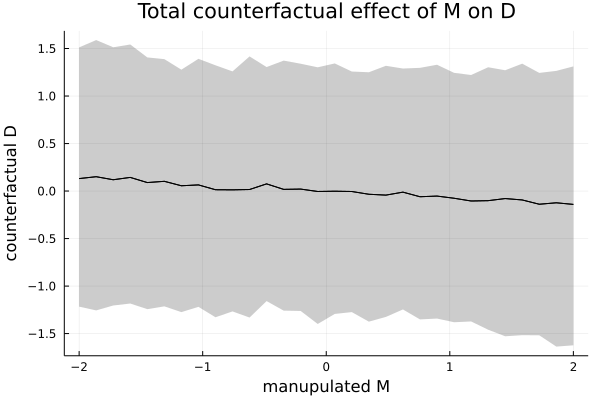

In [31]:
M_seq = range(-2, 2; length=30)
s_D = []

for r ∈ eachrow(m5_3A_df)
    # A is zero, so, we drop it from the μ term
    D = rand(MvNormal((@. r.a + r.bM * M_seq), r.σ))
    push!(s_D, D)
end

s_D = vcat(s_D'...);

μ_D = mean.(eachcol(s_D))
PI_D = vcat(PI.(eachcol(s_D))'...)

plot(
    M_seq, [μ_D, μ_D]; 
    fillrange=PI_D, fillalpha=0.2, color=:black,
    xlab="manupulated M", ylab="counterfactual D",
    title="Total counterfactual effect of M on D"
)

Code 5.25

In [32]:
A_seq = range(-2, 2; length=30);

Code 5.26

In [33]:
s_M = [
    rand(MvNormal((@. r.aM + r.bAM * A_seq), r.σ_M))
    for r ∈ eachrow(m5_3A_df)
]
s_M = vcat(s_M'...);

Code 5.27

In [34]:
s_D = [
    rand(MvNormal((@. r.a + r.bA * A_seq + r.bM * M), r.σ))
    for (r, M) ∈ zip(eachrow(m5_3A_df), eachrow(s_M))
]
s_D = vcat(s_D'...);

# 5.2 Masked relationship

Code 5.28

In [35]:
d = DataFrame(CSV.File("data/milk.csv",  missingstring="NA"))

# get rid of dots in column names
repl = [
    n => replace(n, "." => "_")
    for n in names(d) 
    if '.' ∈ n
]
rename!(d, repl)

describe(d)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,clade,,Ape,,Strepsirrhine,0
2,species,,A palliata,,Symphalangus syndactylus,0
3,kcal_per_g,0.641724,0.46,0.6,0.97,0
4,perc_fat,33.9903,3.93,36.84,55.51,0
5,perc_protein,16.4034,7.37,15.8,25.3,0
6,perc_lactose,49.6062,27.09,48.64,71.91,0
7,mass,14.7269,0.12,3.47,97.72,0
8,neocortex_perc,67.5759,55.16,68.85,76.3,12


Code 5.29

In [36]:
d[!,:K] = standardize(ZScoreTransform, d.kcal_per_g)
d[!,:M] = standardize(ZScoreTransform, log.(d.mass))

# column contains missing values, need to propagate them on standartization
d[!,:N] = d.neocortex_perc
non_miss = findall(!ismissing, d.N);
d[non_miss,:N] = standardize(ZScoreTransform, disallowmissing(d.N[non_miss]));

Code 5.30

In [52]:
@model function model_m5_5_draft(N, K)
    a ~ Normal(0, 1)
    bN ~ Normal(0, 1)
    σ ~ Exponential(1)
    μ = @. a + bN * N
    K ~ MvNormal(μ, σ)
end

try
    m5_5_draft = sample(model_m5_5_draft(d.N, d.K), NUTS(), 1000)
catch e
    if isa(e, MethodError)
        s = sprint(showerror, e)
        println(s)
    end
end

MethodError: no method matching MvNormal(::Vector{Union{Missing, Float64}}, ::Float64)
Closest candidates are:
  MvNormal(!Matched::Tracker.TrackedVector{var"#s50", A} where {var"#s50"<:Real, A}, ::Real) at /home/shmuma/.julia/packages/DistributionsAD/WaBSG/src/tracker.jl:468
  MvNormal(!Matched::AbstractVector{var"#s464"} where var"#s464"<:Real, ::Real) at deprecated.jl:70
  MvNormal(!Matched::Int64, ::Real) at deprecated.jl:70


Code 5.31

In [38]:
d.neocortex_perc

29-element Vector{Union{Missing, Float64}}:
 -2.0801960251136564
   missing
   missing
   missing
   missing
 -0.5086412889378672
 -0.5086412889378672
  0.010742472484833622
   missing
  0.21346968258853227
 -1.4619618058717947
 -0.9861392631490621
 -1.2156733770681267
  ⋮
  0.47483699478834385
   missing
  0.9757910098379835
   missing
 -0.007687273888229892
   missing
  0.6172486713074732
  0.8417564907611553
   missing
  0.44635465948451797
  1.4616661414914773
  1.3259561909261903

Code 5.32

In [39]:
dcc = d[completecases(d[!,[:K,:N,:M]]),:];

Code 5.33

In [40]:
m5_5_draft = sample(model_m5_5_draft(dcc.N, dcc.K), NUTS(), 1000);

Code 5.34

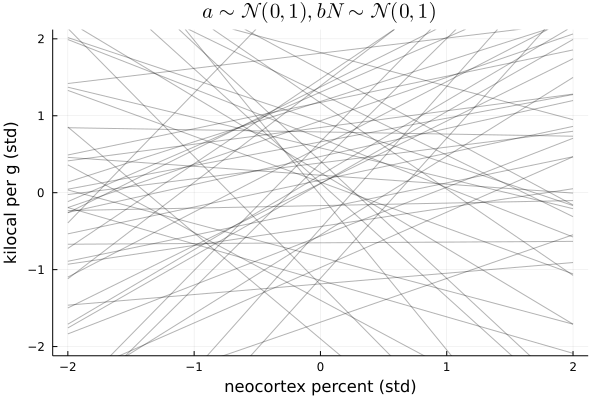

In [41]:
prior = sample(model_m5_5_draft(dcc.N, dcc.K), Prior(), 1000)
prior_df = DataFrame(prior)
xseq = [-2, 2]
μ = StatisticalRethinking.link(prior_df, [:a, :bN], xseq)
μ = hcat(μ...);

p = plot(; xlim=xseq, ylim=xseq, 
    xlab="neocortex percent (std)", ylab="kilocal per g (std)", 
    title=L"a \sim \mathcal{N}(0,1), bN \sim \mathcal{N}(0,1)"
)
for y ∈ first(eachrow(μ), 50)
    plot!(p, xseq, y; c=:black, alpha=0.3)
end
p

Code 5.35

In [42]:
@model function model_m5_5(N, K)
    a ~ Normal(0, 0.2)
    bN ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    μ = @. a + bN * N
    K ~ MvNormal(μ, σ)
end

m5_5 = sample(model_m5_5(dcc.N, dcc.K), NUTS(), 1000)
m5_5_df = DataFrame(m5_5);

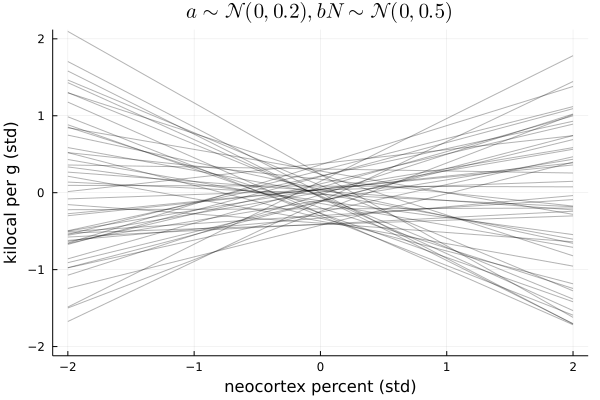

In [43]:
prior = sample(model_m5_5(dcc.N, dcc.K), Prior(), 1000)
prior_df = DataFrame(prior)

μ = StatisticalRethinking.link(prior_df, [:a, :bN], xseq)
μ = hcat(μ...);

p2 = plot(; xlim=xseq, ylim=xseq, 
    xlab="neocortex percent (std)", ylab="kilocal per g (std)", 
    title=L"a \sim \mathcal{N}(0,0.2), bN \sim \mathcal{N}(0,0.5)"
)
for y ∈ first(eachrow(μ), 50)
    plot!(p2, xseq, y; c=:black, alpha=0.3)
end
p2

Code 5.36

In [44]:
precis(m5_5_df)

┌───────┬─────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%   histogram │
├───────┼─────────────────────────────────────────────────────┤
│     a │ 0.0334  0.1498  -0.1915  0.0282  0.2705  ▁▂▅██▆▄▁▁▁ │
│    bN │ 0.1319  0.2462  -0.2434  0.1337  0.5065   ▁▁▂▇██▃▁▁ │
│     σ │ 1.1139  0.1989   0.8441  1.0826  1.4622    ▁▆█▅▂▁▁▁ │
└───────┴─────────────────────────────────────────────────────┘


Code 5.37

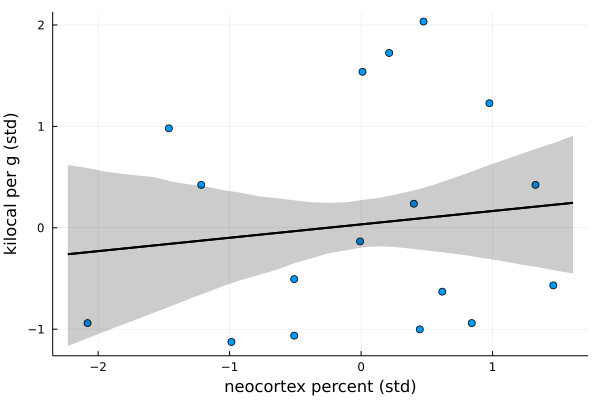

In [45]:
xseq = range(minimum(dcc.N) - 0.15, maximum(dcc.N) + 0.15; length=30)
μ = StatisticalRethinking.link(m5_5_df, [:a, :bN], xseq);
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df dcc scatter(:N, :K; xlab="neocortex percent (std)", ylab="kilocal per g (std)")
plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

Code 5.38

In [55]:
@model function model_m5_6(M, K)
    a ~ Normal(0, 0.2)
    bM ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    μ = @. a + bM * M
    K ~ MvNormal(μ, σ)
end

m5_6 = sample(model_m5_6(dcc.M, dcc.K), NUTS(), 1000)
m5_6_df = DataFrame(m5_6)
precis(m5_6_df)

┌───────┬─────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%   94.5%  histogram │
├───────┼─────────────────────────────────────────────────────┤
│     a │  0.0404  0.1538  -0.1983  0.0336  0.3004  ▁▂▅██▇▃▂▁ │
│    bM │ -0.2782  0.2138  -0.6171  -0.286  0.0818   ▁▂▅█▆▂▁▁ │
│     σ │  1.0623  0.1921    0.805  1.0307  1.3896  ▂██▃▁▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────┘


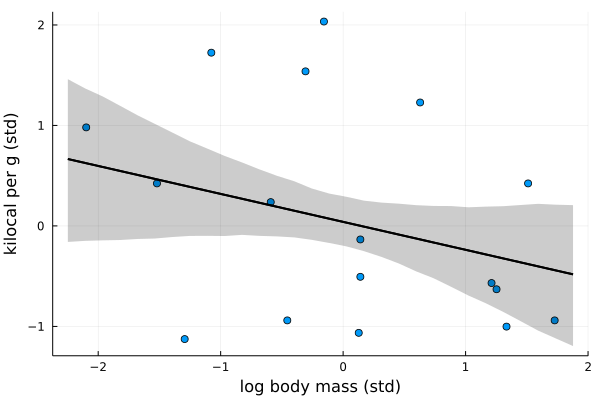

In [56]:
xseq = range(minimum(dcc.M) - 0.15, maximum(dcc.M) + 0.15; length=30)
μ = StatisticalRethinking.link(m5_6_df, [:a, :bM], xseq);
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df dcc scatter(:M, :K; xlab="log body mass (std)", ylab="kilocal per g (std)")
plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

In [57]:
@model function model_m5_7(N, M, K)
    a ~ Normal(0, 0.2)
    bN ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    μ = @. a + bN * N + bM * M
    K ~ MvNormal(μ, σ)
end

m5_7 = sample(model_m5_7(dcc.N, dcc.M, dcc.K), NUTS(), 1000)
m5_7_df = DataFrame(m5_7)
precis(m5_7_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%      histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │  0.0601  0.1544  -0.1894   0.0586  0.3036   ▁▁▁▂▄███▅▂▁▁ │
│    bN │  0.6101  0.2751   0.1488    0.626  1.0283    ▁▁▁▂▄▇█▅▂▁▁ │
│    bM │ -0.6481  0.2322   -0.997  -0.6594  -0.259       ▁▂▆█▆▃▁▁ │
│     σ │  0.8602   0.177   0.6274   0.8329  1.1515  ▂▅██▆▄▂▁▁▁▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


Code 5.40

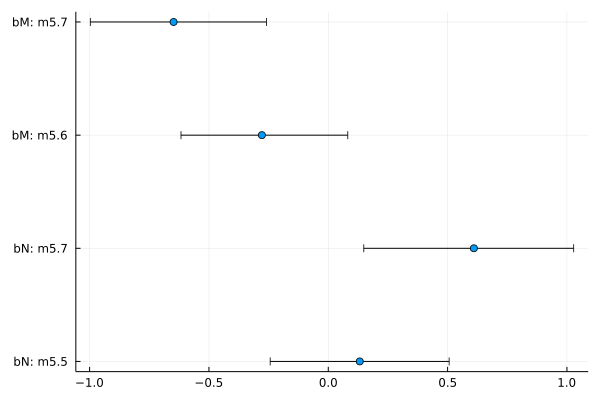

In [60]:
coeftab_plot(m5_7_df, m5_6_df, m5_5_df; pars=(:bM, :bN), names=("m5.7", "m5.6", "m5.5"))

Code 5.41

The code in the book corresponds to the bottom-right figure, which keeps N=0 (despite stated in the text).

Below is the code to produce the bottom-left figure (M=0).

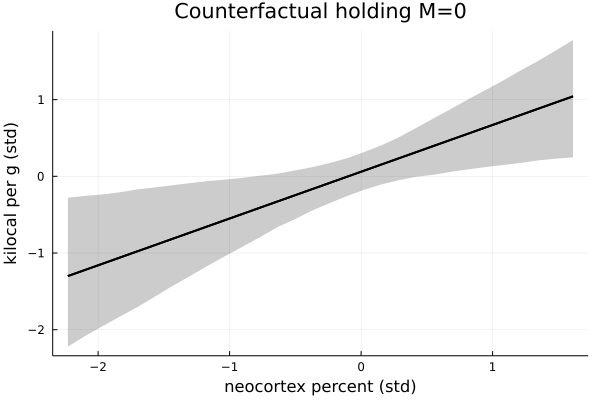

In [67]:
xseq = range(minimum(dcc.N) - 0.15, maximum(dcc.N) + 0.15; length=30)
μ = StatisticalRethinking.link(m5_7_df, [:a, :bN], xseq);
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

plot(title="Counterfactual holding M=0", 
    xlab="neocortex percent (std)", ylab="kilocal per g (std)")
plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

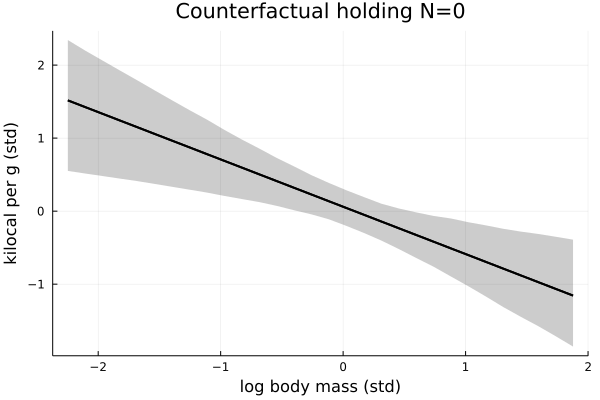

In [68]:
xseq = range(minimum(dcc.M) - 0.15, maximum(dcc.M) + 0.15; length=30)
μ = StatisticalRethinking.link(m5_7_df, [:a, :bM], xseq);
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

plot(title="Counterfactual holding N=0", 
    xlab="log body mass (std)", ylab="kilocal per g (std)")
plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

Code 5.42

In [72]:
# M → K ← N
# M → N
Random.seed!(100)
n = 100
M = rand(Normal(), n)
N = [rand(Normal(μ)) for μ ∈ M]
K = [rand(Normal(μ)) for μ ∈ N .- M] 
d_sim = DataFrame(:K => K, :N => N, :M => M);

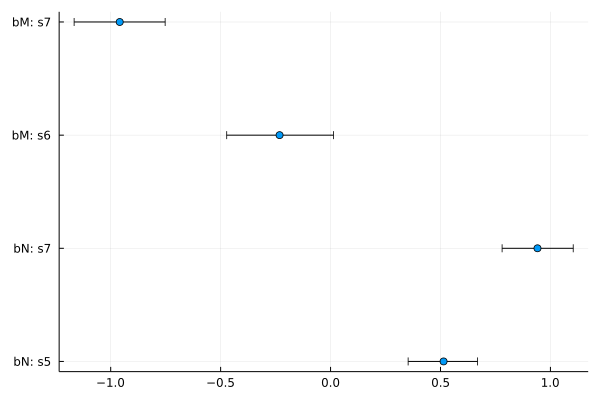

In [78]:
s5 = sample(model_m5_5(d_sim.N, d_sim.K), NUTS(), 1000)
s6 = sample(model_m5_6(d_sim.M, d_sim.K), NUTS(), 1000)
s7 = sample(model_m5_7(d_sim.N, d_sim.M, d_sim.K), NUTS(), 1000)
s5_df = DataFrame(s5)
s6_df = DataFrame(s6)
s7_df = DataFrame(s7)
coeftab_plot(s7_df, s6_df, s5_df; pars=(:bM, :bN), names=("s7", "s6", "s5"))

Code 5.43

In [79]:
Random.seed!(100)

# M → K ← N
# N → M
n = 100
N = rand(Normal(), n)
M = [rand(Normal(μ)) for μ ∈ N]
K = [rand(Normal(μ)) for μ ∈ N .- M] 
d_sim2 = DataFrame(:K => K, :N => N, :M => M);

# M → K ← N
# M ← U → N
n = 100
U = rand(Normal(), n)
N = [rand(Normal(μ)) for μ ∈ U]
M = [rand(Normal(μ)) for μ ∈ U]
K = [rand(Normal(μ)) for μ ∈ N .- M] 
d_sim3 = DataFrame(:K => K, :N => N, :M => M);

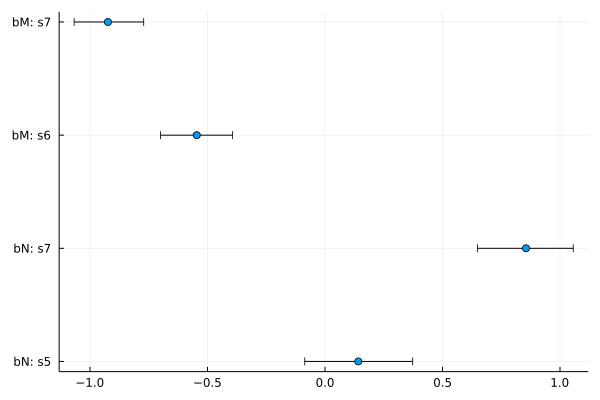

In [80]:
s5 = sample(model_m5_5(d_sim2.N, d_sim2.K), NUTS(), 1000)
s6 = sample(model_m5_6(d_sim2.M, d_sim2.K), NUTS(), 1000)
s7 = sample(model_m5_7(d_sim2.N, d_sim2.M, d_sim2.K), NUTS(), 1000)
s5_df = DataFrame(s5)
s6_df = DataFrame(s6)
s7_df = DataFrame(s7)
coeftab_plot(s7_df, s6_df, s5_df; pars=(:bM, :bN), names=("s7", "s6", "s5"))

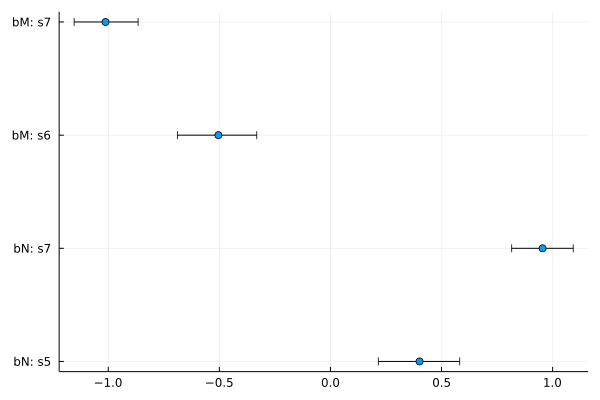

In [94]:
s5 = sample(model_m5_5(d_sim3.N, d_sim3.K), NUTS(), 1000)
s6 = sample(model_m5_6(d_sim3.M, d_sim3.K), NUTS(), 1000)
s7 = sample(model_m5_7(d_sim3.N, d_sim3.M, d_sim3.K), NUTS(), 1000)
s5_df = DataFrame(s5)
s6_df = DataFrame(s6)
s7_df = DataFrame(s7)
coeftab_plot(s7_df, s6_df, s5_df; pars=(:bM, :bN), names=("s7", "s6", "s5"))

Code 5.44

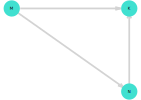

In [97]:
dag5_7 = Dagitty.DAG(:M => :K, :N => :K, :M => :N)
drawdag(dag5_7, [1, 0, 1], [0, 0, 1])

# equivalentDAGs is TODO in Dagitty.jl

# 5.3 Categorical variables